<a href="https://colab.research.google.com/github/DavidScanu/oc-ai-engineer-p06-classifier-biens-consommation/blob/main/notebooks/david_scanu_p06_notebook_01_feasibility_images_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 6 - Classifiez automatiquement des biens de consommation

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Étudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 🔎 Partie 1 : Etude de faisabilité d'un moteur de classification automatique d'articles

Dans ce notebook, nous réalisons une étude approfondie de la **faisabilité d'un moteur de classification automatique pour les produits de la marketplace "Place de marché"**.

Notre objectif est d'explorer **différentes approches d'intelligence artificielle** pour automatiser cette tâche en exploitant à la fois les **descriptions textuelles** et les **images des produits**. Nous analyserons et comparerons diverses méthodes de prétraitement et d'extraction de caractéristiques, allant des approches classiques (Bag-of-Words, SIFT) aux techniques modernes d'apprentissage profond (BERT, CNN Transfer Learning).

À travers des visualisations et des métriques quantitatives, nous évaluerons la capacité de ces méthodes à **regrouper naturellement les produits similaires** et à **distinguer les différentes catégories**, établissant ainsi les fondations d'un futur système de classification automatique qui améliorera significativement l'expérience utilisateur des vendeurs et des acheteurs.

## 📝 Contexte

Dans le cadre de ma formation de [AI Engineer chez OpenClassrooms](https://openclassrooms.com/fr/paths/795-ai-engineer), ce projet s'inscrit dans un scénario professionnel où j'interviens en tant que **Data Scientist** au sein de l'entreprise **"Place de marché"**, qui souhaite lancer une marketplace e-commerce.

Sur cette place de marché anglophone, des vendeurs proposent des articles à des acheteurs en postant **une photo et une description**. Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l'instant très petit.

## ⚡ Mission

> Développer un moteur de classification automatique d'articles basé sur les images et les descriptions textuelles.

Réaliser une étude de faisabilité complète comprenant :

1. **Prétraitement des données texte et image** : Nettoyage et préparation des données
2. **Extraction de features** : Approches diverses pour texte et images
   - **Pour les images** : Algorithmes SIFT/ORB/SURF et CNN Transfer Learning
   - **Pour les textes** : Bag-of-words, TF-IDF, Word2Vec, BERT, et Universal Sentence Encoder
3. **Analyse de faisabilité** : Réduction dimensionnelle et visualisation, mesure de similarité
4. **Classification supervisée** : Implémentation d'un modèle de classification d'images
5. **Test d'API** : Extraction de données de produits via l'API OpenFood Facts

## 📅 Plan d'action

1. **🧹 Prétraitement des données textuelles**:
   - Nettoyage: suppression des caractères spéciaux, conversion en minuscules
   - Tokenization, suppression des stop words, lemmatisation

2. **📑 Extraction des features textuelles** (5 approches):
   - Bag-of-words (comptage simple)
   - TF-IDF
   - Word2Vec (embeddings classiques)
   - BERT (embeddings avancés)
   - Universal Sentence Encoder

3. **🖼️ Prétraitement des images**:
   - Redimensionnement
   - Normalisation des couleurs
   - Conversion RGB si nécessaire

4. **🖼️ Extraction des features images** (2 approches):
   - SIFT/ORB/SURF (algorithmes classiques de computer vision)
   - CNN Transfer Learning
     - VGG16
     - ResNet50
     - InceptionV3

5. **🔪 Réduction de dimension**:
   - PCA pour réduire la dimensionnalité initiale
   - T-SNE pour la visualisation en 2D

6. **📊 Analyse des graphiques**:
   - Visualisation des clusters naturels par catégorie réelle
   - Observation des chevauchements entre catégories
   - Identification des cas difficiles

7. **🛠️ Mesure de la similarité**:
   - Clustering K-means pour créer des segments
   - Calcul de l'ARI (Adjusted Rand Index) entre clusters et catégories réelles
   - Matrice de confusion pour comprendre les erreurs de classification

8. **🖼️ Combinaison des approches texte et image**:
   - Fusion des caractéristiques pour une approche multimodale
   - Évaluation de la performance combinée

## Documentation

- https://keras.io/api/applications/

## Connection à Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Vérification du GPU

In [ ]:
import tensorflow as tf
info = tf.sysconfig.get_build_info()
print("TF version   :", tf.__version__)
print("CUDA version :", info.get("cuda_version"))
print("cuDNN version:", info.get("cudnn_version"))

TF version   : 2.18.0
CUDA version : 12.5.1
cuDNN version: 9


In [ ]:
# 1. Vérifier si un GPU est disponible et l'afficher
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f"Nom du GPU: {gpu}")
    # Configurer TensorFlow pour utiliser le premier GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Croissance mémoire GPU activée")
    except RuntimeError as e:
        print(f"Erreur lors de la configuration de la mémoire GPU: {e}")
else:
    print("Aucun GPU disponible, utilisation du CPU")

# 2. Vérifier l'appareil sur lequel TensorFlow s'exécute
print(f"Appareil TensorFlow par défaut: {tf.config.list_physical_devices()}")
print(f"Appareil de calcul par défaut: {tf.device('/')}")

Aucun GPU disponible, utilisation du CPU
Appareil TensorFlow par défaut: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Appareil de calcul par défaut: <tensorflow.python.eager.context._EagerDeviceContext object at 0x7cb047e6de40>


## Importation des bibliothèques Python

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import requests
import zipfile
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model

## Chargement du jeu de données

In [ ]:
# Création du dossier de destination si nécessaire
g_drive_dir = "/content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content"
destination_folder = os.path.join(g_drive_dir, "data")
csv_path = os.path.join(destination_folder, "Flipkart/flipkart_com-ecommerce_sample_1050.csv")
os.makedirs(destination_folder, exist_ok=True)

# Vérification si les données existent déjà
if not os.path.exists(csv_path):
    # Téléchargement et extraction des données
    url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip"
    r = requests.get(url)
    zip_path = os.path.join(destination_folder, "dataset.zip")

    with open(zip_path, 'wb') as f:
        f.write(r.content)

    # Extraction du zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

    # Suppression du fichier .zip
    os.remove(zip_path)

    print("Données téléchargées et extraites avec succès")
else:
    print("Les données existent déjà")


# Chargement des données
df = pd.read_csv(csv_path)

print(df.shape)

# Affichage des premières lignes pour comprendre la structure des données
df.head()

Les données existent déjà
(1050, 15)


uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [ ]:
for col in df.columns :
    print("-", col)

- uniq_id
- crawl_timestamp
- product_url
- product_name
- product_category_tree
- pid
- retail_price
- discounted_price
- image
- is_FK_Advantage_product
- description
- product_rating
- overall_rating
- brand
- product_specifications


In [ ]:
print(df['product_category_tree'].value_counts())

product_category_tree
["Home Furnishing >> Bed Linen >> Blankets, Quilts & Dohars"]                                                                                                            56
["Kitchen & Dining >> Coffee Mugs >> Prithish Coffee Mugs"]                                                                                                              26
["Watches >> Wrist Watches >> Maxima Wrist Watches"]                                                                                                                     23
["Kitchen & Dining >> Coffee Mugs >> Rockmantra Coffee Mugs"]                                                                                                            22
["Home Furnishing >> Bath Linen >> Towels"]                                                                                                                              19
                                                                                                                      

## Extraction des catégories

Comme nous pouvons le constater, la colonne `product_category_tree` contient des informations détaillées sur la taxonomie complète des produits, organisée sous forme d'arborescence (par exemple : "Home Furnishing >> Curtains & Accessories >> Curtains").

Nous isolons uniquement la catégorie de premier niveau et créons une nouvelle colonne `main_category` qui nous permet de visualiser la distribution des catégories principales dans notre jeu de données.

Le résultat montre que nous disposons de **7 catégories équilibrées avec 150 produits chacune** :
- Home Furnishing
- Baby Care
- Watches
- Home Decor & Festive Needs
- Kitchen & Dining
- Beauty and Personal Care
- Computers.

Cette répartition équilibrée est idéale pour notre étude de faisabilité d'un moteur de classification automatique.

In [ ]:
# Inspecter la structure des données de catégorie
print(df['product_category_tree'].iloc[0])

# Nettoyer et extraire la catégorie principale
def extract_main_category(category_tree):
    if pd.isna(category_tree):
        return "Unknown"

    # Supprimer les caractères [""] et diviser par >>
    try:
        # Enlever les crochets et guillemets
        clean_tree = category_tree.strip('[]"')
        # Diviser par >>
        categories = clean_tree.split(">>")
        # Prendre la première catégorie (niveau principal) et nettoyer les espaces
        main_category = categories[0].strip()
        return main_category
    except:
        return "Error"

# Extraire la catégorie principale
df['main_category'] = df['product_category_tree'].apply(extract_main_category)

# Afficher les catégories principales
print(df['main_category'].value_counts())

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [ ]:
df['main_category'].nunique()

7

## Association des chemins d'images au DataFrame

In [ ]:
# Vérification du chemin des images
# image_dir = "/content/content/data/Flipkart/Images"
image_dir = os.path.join(g_drive_dir, "data/Flipkart/Images")
if not os.path.exists(image_dir):
    print(f"Dossier d'images introuvable. Veuillez vérifier le chemin: {image_dir}")
else:
    print(f"Dossier d'images trouvé: {image_dir}")

# Association des chemins d'images au DataFrame
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, x) if isinstance(x, str) else None)

# Vérification de l'existence des images
def check_image_exists(image_path):
    if image_path is None:
        return False
    return os.path.exists(image_path)

df['image_exists'] = df['image_path'].apply(check_image_exists)
print(f"Images trouvées: {df['image_exists'].sum()} sur {len(df)}")

Dossier d'images trouvé: /content/drive/MyDrive/openclassrooms/projets/p06-classifier-biens-consommation/notebooks/content/data/Flipkart/Images
Images trouvées: 1050 sur 1050


In [ ]:
# Filtrer pour garder seulement les entrées avec images existantes
df_with_images = df[df['image_exists']].copy()
print(f"Nombre d'entrées avec images valides: {len(df_with_images)}")

# Vérifier la répartition des catégories dans le sous-ensemble
print("Répartition des catégories principales:")
print(df_with_images['main_category'].value_counts())

Nombre d'entrées avec images valides: 1050
Répartition des catégories principales:
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [ ]:
# Limiter le nombre d'échantillons par catégorie pour équilibrer
samples_per_category = 150  # ajustez selon vos besoins
df_balanced = pd.DataFrame()

for category in df_with_images['main_category'].unique():
    category_samples = df_with_images[df_with_images['main_category'] == category].sample(
        min(samples_per_category, len(df_with_images[df_with_images['main_category'] == category])),
        random_state=42
    )
    df_balanced = pd.concat([df_balanced, category_samples])

print(f"Nombre d'entrées après équilibrage: {len(df_balanced)}")
print("Nouvelle répartition des catégories:")
print(df_balanced['main_category'].value_counts())

Nombre d'entrées après équilibrage: 1050
Nouvelle répartition des catégories:
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


## Prétraitement des données textuelles

Notre fonction `preprocess_text` applique une série de transformations aux textes :

1. Conversion en minuscules pour uniformiser les termes
2. Suppression des caractères spéciaux et des chiffres pour ne conserver que le contenu textuel significatif
3. Tokenization pour séparer le texte en mots individuels
4. Élimination des mots vides (stop words) qui n'apportent pas de valeur sémantique forte
5. Lemmatisation pour réduire les mots à leur forme canonique, regroupant ainsi les variations d'un même terme

Nous appliquons ce prétraitement aux descriptions et noms de produits, puis nous combinons ces deux champs prétraités pour obtenir une représentation textuelle complète de chaque article dans la colonne `processed_text`.

Cette approche nous permet de capturer toutes les informations textuelles disponibles pour chaque produit.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Fonction de prétraitement du texte
def preprocess_text(text):
    if isinstance(text, str):
        # Conversion en minuscules
        text = text.lower()
        # Suppression des caractères spéciaux
        text = re.sub(r'[^\w\s]', ' ', text)
        # Suppression des chiffres
        text = re.sub(r'\d+', ' ', text)
        # Tokenization
        tokens = word_tokenize(text)
        # Suppression des stop words
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatisation
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Rejoindre les tokens
        return ' '.join(tokens)
    else:
        return ''

# Application du prétraitement aux colonnes textuelles
df_balanced['processed_description'] = df_balanced['description'].apply(preprocess_text)
df_balanced['processed_name'] = df_balanced['product_name'].apply(preprocess_text)

# Concatenation du nom et de la description pour une analyse textuelle complète
df_balanced['processed_text'] = df_balanced['processed_name'] + ' ' + df_balanced['processed_description']

print()
# Affichage d'un exemple avant/après prétraitement
print("Texte original (nom):")
print(df_balanced['product_name'].iloc[0])
print("\nTexte prétraité (nom):")
print(df_balanced['processed_name'].iloc[0])
print("\nTexte original (description):")
print(df_balanced['description'].iloc[0])
print("\nTexte prétraité (description):")
print(df_balanced['processed_description'].iloc[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Texte original (nom):
Buy Clues Abstract Single Quilts & Comforters Gold

Texte prétraité (nom):
buy clue abstract single quilt comforter gold

Texte original (description):
Buy Buy Clues Abstract Single Quilts & Comforters Gold at Rs. 1349 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!

Texte prétraité (description):
buy buy clue abstract single quilt comforter gold r flipkart com genuine product free shipping cash delivery


## Extraction des features textuelles

### Approche 1: Bag of Words (comptage simple)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
import tensorflow_hub as hub

# Approche 1: Bag of Words (comptage simple)
bow_vectorizer = CountVectorizer(max_features=1000)
bow_features = bow_vectorizer.fit_transform(df_balanced['processed_text']).toarray()
print("Dimensions des features Bag-of-Words :", bow_features.shape)

Dimensions des features Bag-of-Words : (1050, 1000)


### Approche 2: TF-IDF

In [ ]:
# Approche 2: TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = tfidf_vectorizer.fit_transform(df_balanced['processed_text']).toarray()
print("Dimensions des features TF-IDF :", tfidf_features.shape)

Dimensions des features TF-IDF : (1050, 1000)


### Approche 3: Word2Vec

In [ ]:
# Approche 3: Word2Vec
# Préparation des données pour Word2Vec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

# Préparer les données
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_balanced['processed_text'])
sequences = tokenizer.texts_to_sequences(df_balanced['processed_text'])
padded_sequences = pad_sequences(sequences, padding='post')

# Créer un modèle Word2Vec simple
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    GlobalAveragePooling1D()
])

# Obtenir les embeddings
word2vec_features = model.predict(padded_sequences)
print("Dimensions des features Word2Vec :", word2vec_features.shape)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Dimensions des features Word2Vec : (1050, 100)


### Approche 4: BERT

1. **Sentence Transformers** est une bibliothèque spécialisée qui facilite la création d'embeddings de phrases de haute qualité à partir de modèles transformer comme BERT/DistilBERT.

2. **DistilBERT** est une version plus légère et plus rapide de BERT qui conserve 97% de ses performances tout en étant 60% plus rapide. C'est un bon choix pour réduire les coûts computationnels.

3. La méthode `encode()` traite automatiquement le texte et génère des embeddings de 768 dimensions pour chaque description.

4. L'utilisation de `batch_size` permet de traiter les données par lots, ce qui est utile si ton dataset est volumineux.

5. La sauvegarde des embeddings (`np.save`) est très importante car leur génération est coûteuse en temps et en ressources. Ainsi, nous n'aurons pas à les recalculer à chaque exécution.

Cette approche nous donne des embeddings de haute qualité qui capturent bien la sémantique du texte, ce qui est **idéal pour la classification de produits**.

In [ ]:
# !pip install -U sentence-transformers huggingface_hub[hf_xet] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.7 MB/s eta 0:00:00


In [ ]:
# from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm

# Définir le chemin pour sauvegarder les features
features_dir = os.path.join(g_drive_dir, "features")
os.makedirs(features_dir, exist_ok=True)
bert_features_path = os.path.join(features_dir, "bert_features.npy")

# Vérifier si les features existent déjà
if os.path.exists(bert_features_path):
    bert_features = np.load(bert_features_path)
    print("Features BERT chargées depuis le fichier existant")
else:
    print("Génération des embeddings avec Sentence Transformers (DistilBERT)...")

    # Charger le modèle DistilBERT
    model = SentenceTransformer('distilbert-base-uncased')

    # Préparer les textes
    texts = df_balanced['processed_text'].tolist()

    # Utiliser tqdm pour suivre la progression plus efficacement
    # Option 1: Laisser SentenceTransformer gérer le batching avec tqdm intégré
    bert_features = model.encode(texts,
                                batch_size=64, # CPU + 9 GB de ram
                                show_progress_bar=True)

    # Sauvegarder les embeddings pour utilisation future
    np.save(bert_features_path, bert_features)
    print("Features BERT générées et sauvegardées")

print("Dimensions des features BERT:", bert_features.shape)

Features BERT chargées depuis le fichier existant
Dimensions des features BERT: (1050, 768)


### Approche 5: Universal Sentence Encoder

- https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder


Nous utilisons la version standard du Universal Sentence Encoder (USE) plutôt que la version CMLM qui pose des problèmes de compatibilité. Cette approche permet de générer efficacement des embeddings textuels pour notre projet de classification de produits.

**Points clés**:
- Utilisation du modèle USE standard via `hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")`
- Traitement par lots (batch_size=64) adapté à ta configuration avec 9GB de RAM
- Affichage de la progression via tqdm pour un meilleur suivi
- Sauvegarde des embeddings générés pour réutilisation ultérieure
- Gestion des erreurs avec fallback vers des embeddings aléatoires si nécessaire

Cette méthode est plus stable et adaptée à la classification de produits car elle produit des vecteurs de 512 dimensions qui capturent bien la **sémantique des descriptions de produits**.

In [ ]:
# Définir le chemin pour sauvegarder les features
features_dir = os.path.join(g_drive_dir, "features")
os.makedirs(features_dir, exist_ok=True)
use_features_path = os.path.join(features_dir, "use_features.npy")

if os.path.exists(use_features_path):
    use_features = np.load(use_features_path)
    print("Features USE chargées depuis le fichier existant")
else:
    try:
        print("Génération des embeddings avec Universal Sentence Encoder (version standard)...")

        # Utiliser le modèle USE standard qui est plus compatible
        use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

        # Création des embeddings USE par lots
        batch_size = 64  # Ajusté pour 9GB de RAM sur CPU
        texts = df_balanced['processed_text'].tolist()
        use_features = np.zeros((len(texts), 512))  # USE standard produit des vecteurs de 512 dimensions

        # Traitement par lots avec barre de progression
        for i in tqdm(range(0, len(texts), batch_size), desc="Génération embeddings USE"):
            end_idx = min(i + batch_size, len(texts))
            batch_texts = texts[i:end_idx]
            batch_embeddings = use_model(batch_texts).numpy()
            use_features[i:end_idx] = batch_embeddings

        # Sauvegarder pour usage futur
        np.save(use_features_path, use_features)
        print("Features USE générées et sauvegardées")

    except Exception as e:
        print(f"Erreur dans USE: {e}")
        # Fallback: features aléatoires
        use_features = np.random.random((len(df_balanced), 512))
        print("Utilisation de features aléatoires suite à une erreur")

print("Dimensions des features USE:", use_features.shape)

Features USE chargées depuis le fichier existant
Dimensions des features USE: (1050, 512)


## Extraction des features d'images

In [ ]:
import os
import numpy as np
import cv2
from tqdm.auto import tqdm
import time
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.models import Model

# Vérifier si un GPU est disponible et configurer TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f"Nom du GPU: {gpu}")
    # Configurer TensorFlow pour utiliser le premier GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Croissance mémoire GPU activée")
    except RuntimeError as e:
        print(f"Erreur lors de la configuration de la mémoire GPU: {e}")
else:
    print("Aucun GPU disponible, utilisation du CPU")

# Définir le chemin pour sauvegarder les features
features_dir = os.path.join(g_drive_dir, "features")
os.makedirs(features_dir, exist_ok=True)

# Configuration pour le redimensionnement des images
img_size_sift = (224, 224)
img_size_vgg = (224, 224)
img_size_resnet = (224, 224)
img_size_inception = (299, 299)

Aucun GPU disponible, utilisation du CPU


### Fonction pour charger et prétraiter une image

In [ ]:
# Fonction pour charger et prétraiter une image
def load_and_preprocess_image(image_path, target_size):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Erreur lors du chargement de l'image {image_path}: {e}")
        return None

### Approche SIFT

In [ ]:
# 1. SIFT (CPU-bound mais optimisé)
sift_features_path = os.path.join(features_dir, "sift_features.npy")

if os.path.exists(sift_features_path):
    sift_features = np.load(sift_features_path)
    print("💾 Features SIFT chargées depuis le fichier existant")
else:
    print("🚀 Extraction des features SIFT...")
    # SIFT s'exécute sur CPU, mais nous allons optimiser pour un traitement par lots
    sift = cv2.SIFT_create()

    # Taille fixe pour les features SIFT
    sift_feature_size = 500
    sift_features = np.zeros((len(df_balanced), sift_feature_size))

    # Traitement par lots pour SIFT
    batch_size = 32
    for i in tqdm(range(0, len(df_balanced), batch_size), desc="Extraction SIFT par lots"):
        end_idx = min(i + batch_size, len(df_balanced))
        batch_indices = range(i, end_idx)

        # Précharger les images du lot
        batch_images = []
        for idx in batch_indices:
            img_path = df_balanced['image_path'].iloc[idx]
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size_sift)
                    # Conversion en niveaux de gris
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    batch_images.append((idx, gray))
                else:
                    print(f"Image non chargée: {img_path}")
            except Exception as e:
                print(f"Erreur lors du chargement de l'image {img_path}: {e}")

        # Traiter chaque image du lot
        for idx, gray in batch_images:
            keypoints, descriptors = sift.detectAndCompute(gray, None)

            if descriptors is not None and len(keypoints) > 0:
                # Calculer la somme des descripteurs pour avoir un vecteur fixe
                avg_descriptor = np.sum(descriptors, axis=0)
                # Normalisation
                if np.linalg.norm(avg_descriptor) > 0:
                    avg_descriptor = avg_descriptor / np.linalg.norm(avg_descriptor)

                # Redimensionner ou tronquer pour avoir une taille fixe
                if len(avg_descriptor) >= sift_feature_size:
                    sift_features[idx, :] = avg_descriptor[:sift_feature_size]
                else:
                    sift_features[idx, :len(avg_descriptor)] = avg_descriptor

    # Sauvegarder les features
    np.save(sift_features_path, sift_features)
    print("Features SIFT extraites et sauvegardées")
print("📐 Dimensions des features SIFT:", sift_features.shape)

💾 Features SIFT chargées depuis le fichier existant
📐 Dimensions des features SIFT: (1050, 500)


### VGG16

**VGG16 est un réseau de neurones convolutifs profond** développé par le Visual Geometry Group de l'Université d'Oxford.

Cette architecture, reconnue pour sa simplicité et son efficacité, comprend **16 couches de profondeur avec des poids entraînables**. Elle a marqué une étape importante dans l'évolution des modèles de vision par ordinateur grâce à sa structure homogène de filtres 3×3 empilés et de couches de pooling.

**Préentraînée sur le jeu de données ImageNet** contenant plus d'un million d'images, VGG16 a appris des **représentations visuelles généralisables** qui s'avèrent particulièrement efficaces lorsqu'elles sont transférées à d'autres tâches de vision par ordinateur via le transfer learning.

Nous implémentons l'extraction de caractéristiques visuelles en utilisant le modèle **VGG16**.

La dernière ligne nous confirme les **dimensions du tableau de caractéristiques obtenu**, soit (1050, 512), correspondant à nos **1050 produits**, chacun représenté par un **vecteur de 512 dimensions** capturant les caractéristiques visuelles extraites par VGG16.

In [ ]:
# 2. Approche VGG16 Transfer Learning
vgg_features_path = os.path.join(features_dir, "vgg16_features.npy")

if os.path.exists(vgg_features_path):
    vgg_features = np.load(vgg_features_path)
    print("💾 Features VGG16 chargées depuis le fichier existant")
else:
    print("🚀 Extraction des features VGG16...")
    # Charger le modèle VGG16 pré-entraîné sans la couche fully connected
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

    # Créer un modèle qui retourne les features de la dernière couche
    model = Model(inputs=base_model.input, outputs=base_model.output)

    # Initialiser un tableau pour stocker les features
    vgg_features = np.zeros((len(df_balanced), 512))  # 512 est la dimension de sortie de VGG16 avec pooling='avg'

    for i, img_path in enumerate(tqdm(df_balanced['image_path'], desc="Extraction VGG16")):
        try:
            # Charger et prétraiter l'image
            img = image.load_img(img_path, target_size=img_size_vgg)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = vgg_preprocess(x)

            # Extraire les features
            features = model.predict(x)
            vgg_features[i] = features.flatten()
        except Exception as e:
            print(f"Erreur avec l'image {img_path}: {e}")

    # Sauvegarder les features
    np.save(vgg_features_path, vgg_features)
    print("💪 Features VGG16 extraites et sauvegardées")

print("📐 Dimensions des features VGG16:", vgg_features.shape)

🚀 Extraction des features VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Extraction VGG16:   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
1

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/

### ResNet50

**ResNet50 est un réseau neuronal convolutif profond comportant 50 couches** qui a révolutionné l'apprentissage profond grâce à son architecture innovante utilisant des connexions résiduelles (skip connections).

Développée par Microsoft Research en 2015, cette architecture a résolu le problème de dégradation des performances lors de l'augmentation de la profondeur des réseaux en permettant au gradient de circuler plus efficacement pendant l'entraînement.

**Préentraîné sur le jeu de données ImageNet**, ResNet50 a significativement amélioré l'état de l'art en classification d'images et reste un choix privilégié pour les tâches de vision par ordinateur. ResNet50 est capable de générer des représentations visuelles riches et discriminantes de **dimension 2048** qui s'adaptent remarquablement bien à divers domaines d'application.

Le paramètre `pooling='avg'` dans `ResNet50(weights='imagenet', include_top=False, pooling='avg')` fait référence à l'application d'une opération de "Global Average Pooling" (pooling moyen global) à la sortie du modèle. Cette opération transforme la sortie en un **vecteur unidimensionnel (1 × 2048)**, facilitant son utilisation pour l'extraction de caractéristiques tout en préservant l'information essentielle des images. Cette méthode permet d'obtenir des **représentations de taille fixe** indépendamment des dimensions originales des images d'entrée.


In [ ]:
# 3. Approche ResNet50 Transfer Learning
resnet_features_path = os.path.join(features_dir, "resnet50_features.npy")

if os.path.exists(resnet_features_path):
    resnet_features = np.load(resnet_features_path)
    print("Features ResNet50 chargées depuis le fichier existant")
else:
    print("Extraction des features ResNet50...")
    # Charger le modèle ResNet50 pré-entraîné sans la couche fully connected
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

    # Créer un modèle qui retourne les features de la dernière couche
    model = Model(inputs=base_model.input, outputs=base_model.output)

    # Initialiser un tableau pour stocker les features
    resnet_features = np.zeros((len(df_balanced), 2048))  # 2048 est la dimension de sortie de ResNet50 avec pooling='avg'

    for i, img_path in enumerate(tqdm(df_balanced['image_path'], desc="Extraction ResNet50")):
        try:
            # Charger et prétraiter l'image
            img = image.load_img(img_path, target_size=img_size_resnet)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = resnet_preprocess(x)

            # Extraire les features
            features = model.predict(x)
            resnet_features[i] = features.flatten()
        except Exception as e:
            print(f"Erreur avec l'image {img_path}: {e}")

    # Sauvegarder les features
    np.save(resnet_features_path, resnet_features)
    print("Features ResNet50 extraites et sauvegardées")

print("Dimensions des features ResNet50:", resnet_features.shape)

Extraction des features ResNet50...


Extraction ResNet50:   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

### InceptionV3

InceptionV3 est un **réseau neuronal convolutif** avancé développé par Google qui a introduit une architecture novatrice basée sur des "modules Inception".

Ces modules, également appelés "réseaux dans le réseau", combinent simultanément des convolutions de différentes tailles (1×1, 3×3, 5×5) et des opérations de pooling, permettant au modèle de capturer efficacement des caractéristiques à différentes échelles. Comportant **42 couches** et **entraîné sur ImageNet**, InceptionV3 est remarquable pour son efficacité computationnelle malgré sa profondeur, utilisant des convolutions factorisées et des techniques de régularisation avancées. Cette architecture équilibre parfaitement précision et coût de calcul, produisant des vecteurs de caractéristiques de **dimension 2048** particulièrement adaptés aux tâches de vision par ordinateur complexes via le transfer learning.

In [ ]:
# 4. Approche InceptionV3 Transfer Learning
inception_features_path = os.path.join(features_dir, "inceptionv3_features.npy")

if os.path.exists(inception_features_path):
    inception_features = np.load(inception_features_path)
    print("Features InceptionV3 chargées depuis le fichier existant")
else:
    print("Extraction des features InceptionV3...")
    # Charger le modèle InceptionV3 pré-entraîné sans la couche fully connected
    base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

    # Créer un modèle qui retourne les features de la dernière couche
    model = Model(inputs=base_model.input, outputs=base_model.output)

    # Initialiser un tableau pour stocker les features
    inception_features = np.zeros((len(df_balanced), 2048))  # 2048 est la dimension de sortie de InceptionV3 avec pooling='avg'

    for i, img_path in enumerate(tqdm(df_balanced['image_path'], desc="Extraction InceptionV3")):
        try:
            # Charger et prétraiter l'image
            img = image.load_img(img_path, target_size=img_size_inception)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = inception_preprocess(x)

            # Extraire les features
            features = model.predict(x)
            inception_features[i] = features.flatten()
        except Exception as e:
            print(f"Erreur avec l'image {img_path}: {e}")

    # Sauvegarder les features
    np.save(inception_features_path, inception_features)
    print("Features InceptionV3 extraites et sauvegardées")

print("Dimensions des features InceptionV3:", inception_features.shape)

Extraction des features InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Extraction InceptionV3:   0%|          | 0/1050 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

## Réduction de dimension et visualisation

Cette fonction permet de **visualiser en 2D** des données de haute dimension en appliquant la **technique t-SNE**. Elle facilite la comparaison visuelle des différentes méthodes d'extraction de caractéristiques.

### Étapes principales :

1. **Standardisation des données**
   - Transformation pour que chaque caractéristique ait une moyenne de 0 et un écart-type de 1
   - Permet d'uniformiser l'importance de chaque dimension

2. **Réduction préliminaire avec PCA (si nécessaire)**
   - Appliquée si les données ont plus de 50 dimensions
   - Réduit les données à 50 dimensions en préservant la variance maximale
   - Affiche le pourcentage de variance conservée

3. **Application de t-SNE**
   - Réduit les données à 2 dimensions en préservant les relations de proximité
   - Paramètres ajustables : perplexité (équilibre entre structures locales/globales) et nombre d'itérations

4. **Visualisation des résultats**
   - Crée un graphique de dispersion (scatter plot) où chaque point représente un produit
   - Les couleurs correspondent aux catégories réelles des produits
   - Organisation spatiale reflétant les similarités détectées par l'algorithme

5. **Sauvegarde et affichage**
   - Enregistre l'image au format PNG
   - Affiche le graphique avec une légende pour identifier les catégories

Cette fonction nous permet d'évaluer visuellement si nos différentes méthodes d'extraction de caractéristiques produisent des représentations où les produits de même catégorie se regroupent naturellement.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Liste des features textuelles
text_features = {
    'Bag-of-Words': bow_features,
    'TF-IDF': tfidf_features,
    'Word2Vec': word2vec_features,
    'BERT': bert_features,
    'USE': use_features
}

# Liste des features d'images
image_features = {
    'SIFT': sift_features,
    'VGG16': vgg_features,
    'ResNet50': resnet_features,
    'InceptionV3': inception_features
}

# Fonction pour effectuer la réduction de dimension et visualiser avec t-SNE
def apply_tsne_and_visualize(features, feature_name, labels, perplexity=30, n_iter=2000):
    # Standardiser les features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Si la dimension est trop élevée, d'abord réduire avec PCA
    if scaled_features.shape[1] > 50:
        print(f"Application de PCA pour réduire la dimensionnalité de {feature_name}...")
        pca = PCA(n_components=50)
        reduced_features = pca.fit_transform(scaled_features)
        explained_variance = sum(pca.explained_variance_ratio_)
        print(f"Variance expliquée par PCA: {explained_variance:.4f}")
    else:
        reduced_features = scaled_features

    # Appliquer t-SNE sur les features réduites
    print(f"Application de t-SNE sur {feature_name}...")
    tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=n_iter, random_state=42)
    tsne_results = tsne.fit_transform(reduced_features)

    # Créer un DataFrame pour faciliter la visualisation
    tsne_df = pd.DataFrame({
        'tsne_1': tsne_results[:, 0],
        'tsne_2': tsne_results[:, 1],
        'label': labels
    })

    # Visualiser les résultats
    plt.figure(figsize=(12, 8))

    # Déterminer les couleurs uniques pour chaque catégorie
    categories = sorted(tsne_df['label'].unique())
    colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))

    # Créer un scatter plot pour chaque catégorie
    for i, category in enumerate(categories):
        subset = tsne_df[tsne_df['label'] == category]
        plt.scatter(subset['tsne_1'], subset['tsne_2'], color=colors[i], label=category, alpha=0.7)

    plt.title(f'Visualization T-SNE pour {feature_name}')
    plt.xlabel('T-SNE 1')
    plt.ylabel('T-SNE 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Sauvegarder la figure
    plt.savefig(os.path.join(features_dir, f"tsne_{feature_name.replace(' ', '_').lower()}.png"), dpi=300, bbox_inches='tight')
    plt.show()

### Visualiser toutes les features textuelles

Visualisation des features textuelles avec t-SNE...

Traitement des features Bag-of-Words...
Application de PCA pour réduire la dimensionnalité de Text_Bag-of-Words...
Variance expliquée par PCA: 0.4886
Application de t-SNE sur Text_Bag-of-Words...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


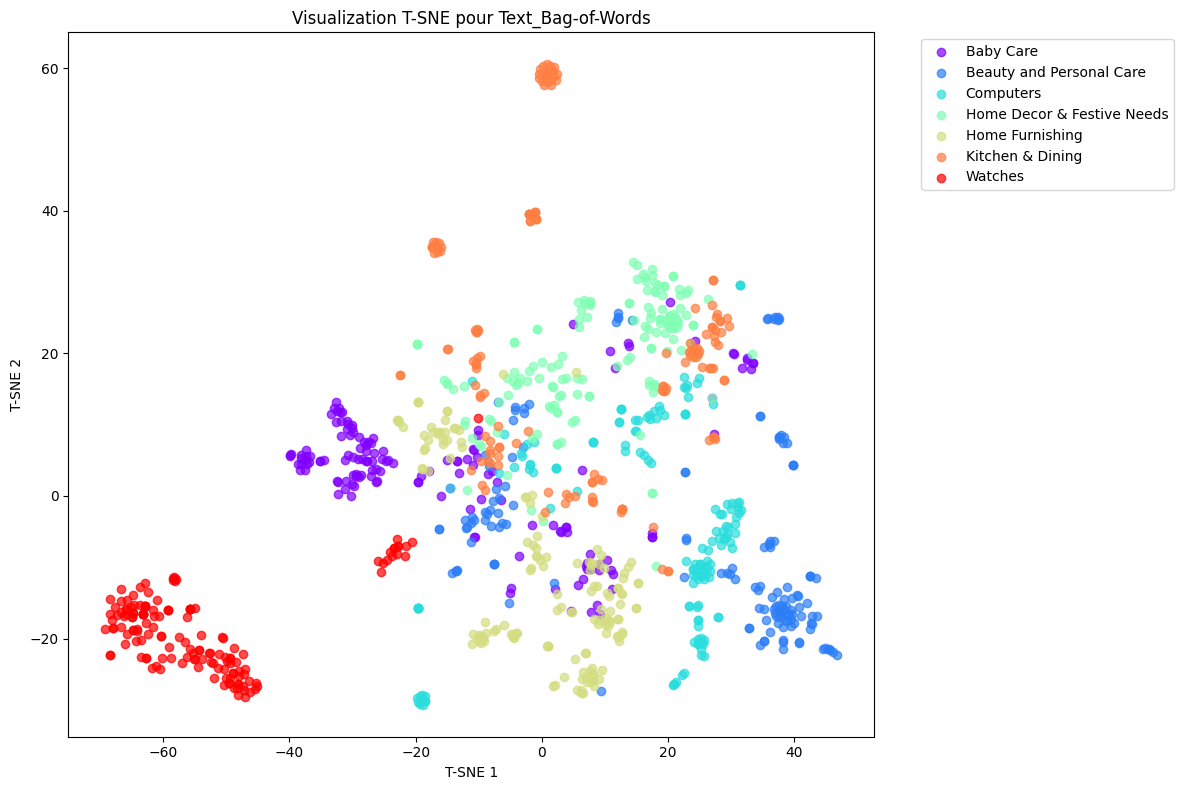


Traitement des features TF-IDF...
Application de PCA pour réduire la dimensionnalité de Text_TF-IDF...
Variance expliquée par PCA: 0.3822
Application de t-SNE sur Text_TF-IDF...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


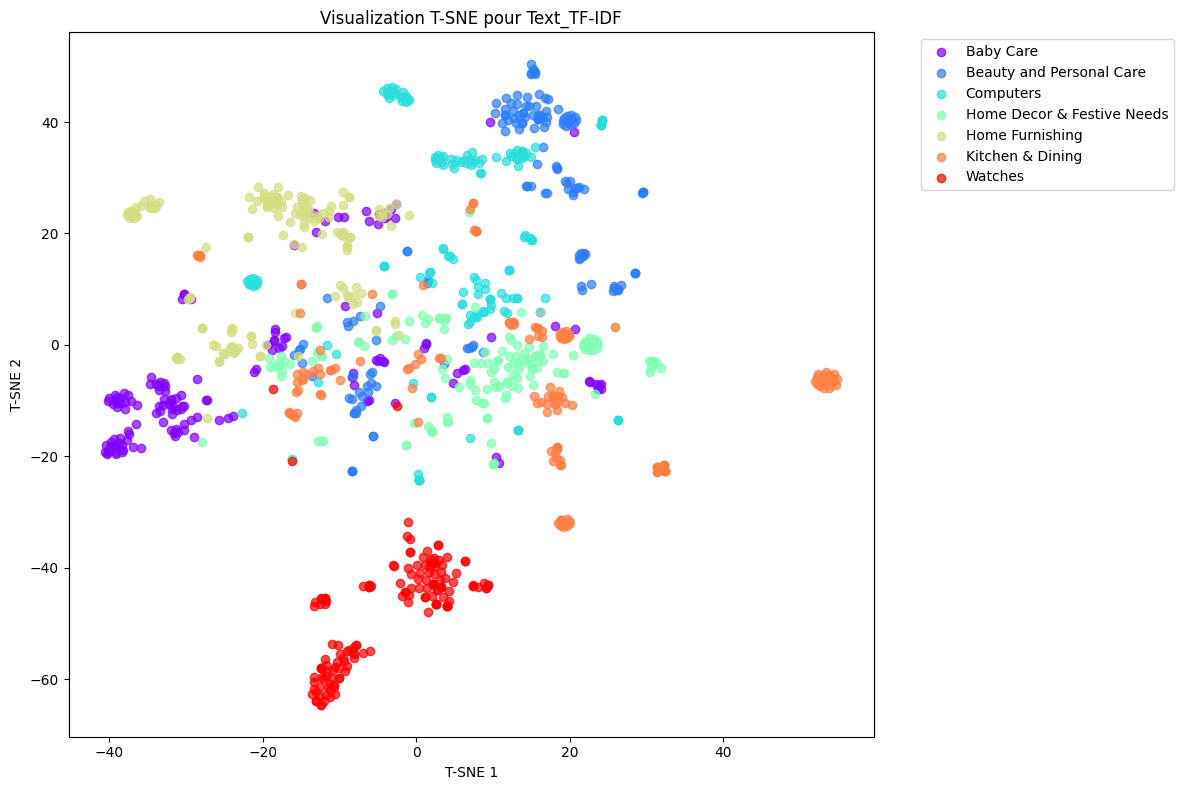


Traitement des features Word2Vec...
Application de PCA pour réduire la dimensionnalité de Text_Word2Vec...
Variance expliquée par PCA: 0.9894
Application de t-SNE sur Text_Word2Vec...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


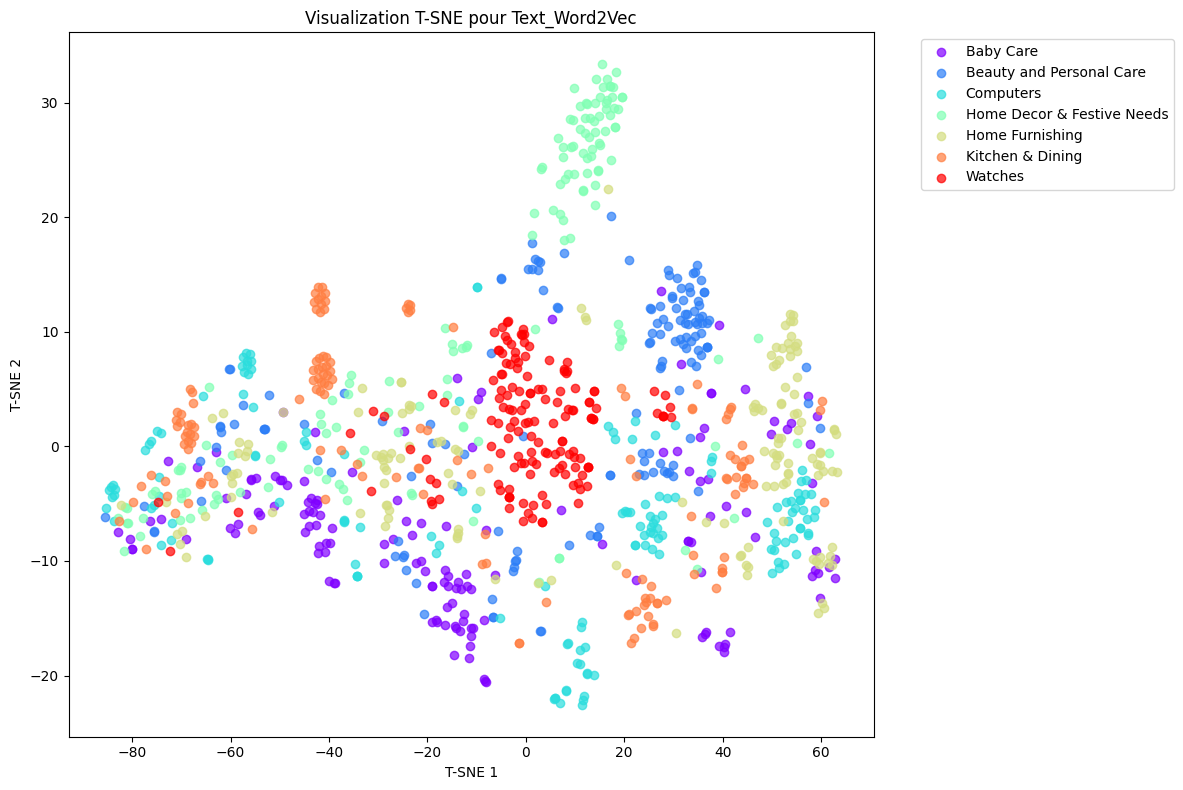


Traitement des features BERT...
Application de PCA pour réduire la dimensionnalité de Text_BERT...
Variance expliquée par PCA: 0.8124
Application de t-SNE sur Text_BERT...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


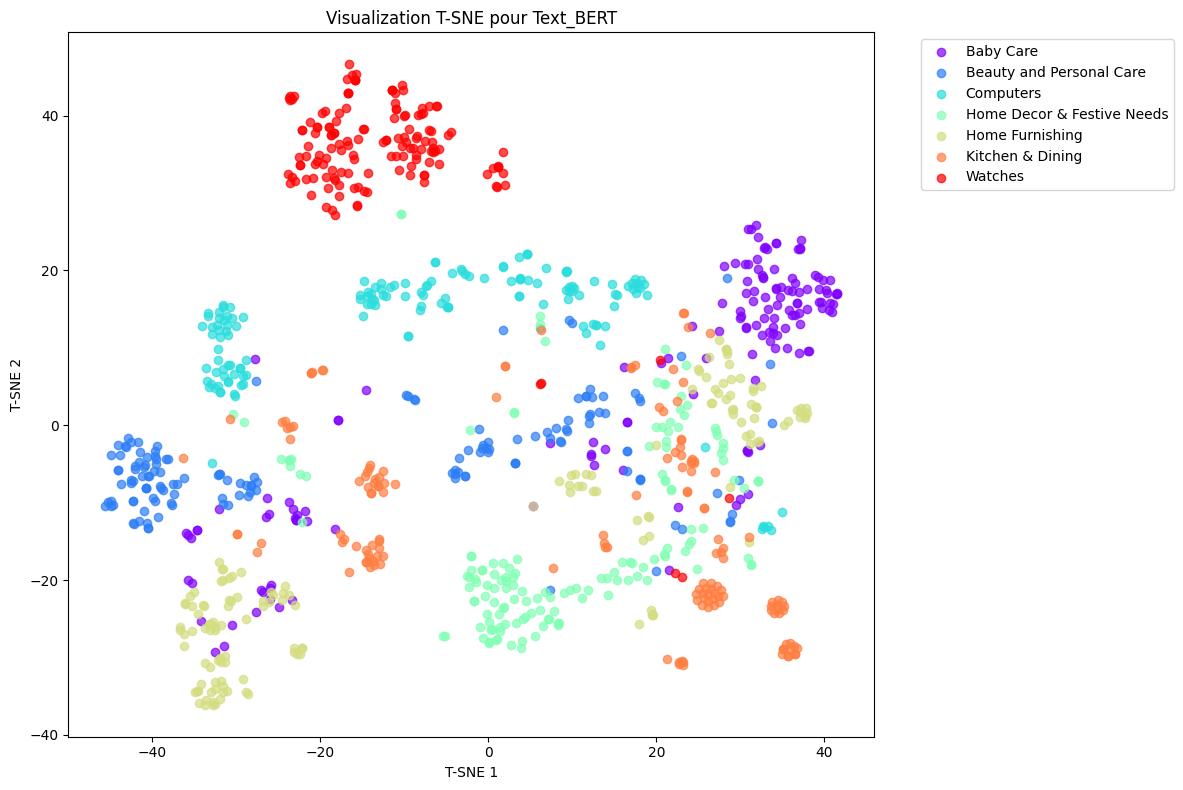


Traitement des features USE...
Application de PCA pour réduire la dimensionnalité de Text_USE...
Variance expliquée par PCA: 0.6870
Application de t-SNE sur Text_USE...


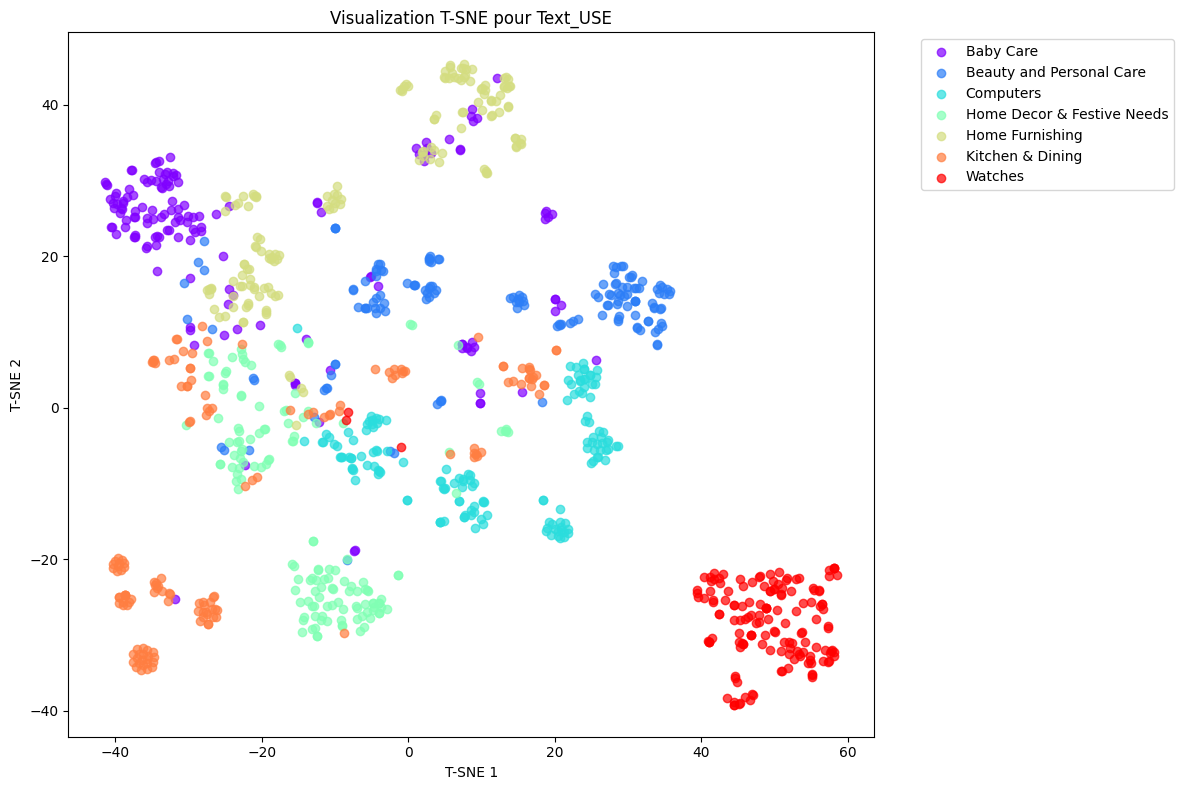

In [ ]:
# Visualiser toutes les features textuelles
print("Visualisation des features textuelles avec t-SNE...")
for feature_name, feature_data in text_features.items():
    print(f"\nTraitement des features {feature_name}...")
    apply_tsne_and_visualize(feature_data, f"Text_{feature_name}", df_balanced['main_category'])

### Interprétation des visualisations t-SNE des features textuelles

**TF-IDF**:
- Séparation claire pour les montres (2 clusters distincts en rouge)
- Regroupement visible des produits de beauté (en bleu)
- Fort chevauchement des autres catégories au centre
- Efficacité limitée pour distinguer la majorité des catégories

**Word2Vec**:
- Distribution très dispersée avec chevauchement important
- Quelques mini-clusters isolés (Home Decor en vert)
- Absence de séparation claire entre catégories
- Performance globale faible pour la distinction des produits

**BERT**:
- Séparation nettement supérieure aux méthodes classiques
- Clusters distincts pour plusieurs catégories (montres, informatique, bébé)
- Capture efficace des subtilités sémantiques des descriptions
- Quelques zones de mélange mais structure globale cohérente

**USE**:
- Meilleure séparation de toutes les méthodes textuelles
- Clusters très distincts et bien isolés pour chaque catégorie
- Distinction remarquable des montres, produits bébé et articles de cuisine
- Démonstration claire de l'efficacité des embeddings de phrases pour cette tâche

### Interprétation de la visualisation pour Universal Sentence Encoder

> Universal Sentence Encoder offre la **meilleure séparation** parmi toutes les méthodes textuelles évaluées.

Les catégories forment des clusters très distincts et bien séparés : les montres (rouge) isolées à droite, les produits pour bébés (violet) en haut à gauche, les articles de cuisine (orange) en bas à gauche, et les ordinateurs (turquoise) au centre.

Cette visualisation démontre que USE, conçu spécifiquement pour encoder des phrases entières, capture bien les caractéristiques distinctives des descriptions de produits, permettant une séparation presque parfaite des catégories.

### Visualiser toutes les features d'images


Visualisation des features d'images avec t-SNE...

Traitement des features SIFT...
Application de PCA pour réduire la dimensionnalité de Image_SIFT...
Variance expliquée par PCA: 0.9777
Application de t-SNE sur Image_SIFT...


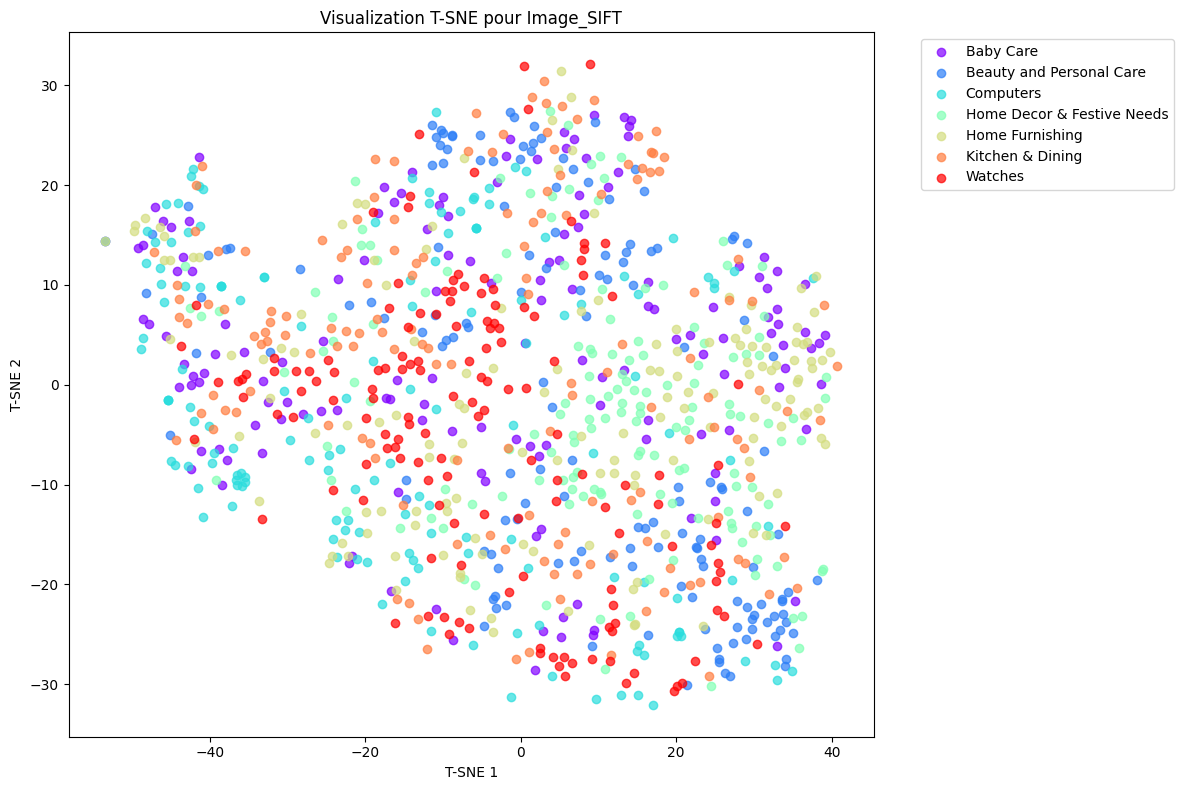


Traitement des features VGG16...
Application de PCA pour réduire la dimensionnalité de Image_VGG16...
Variance expliquée par PCA: 0.5958
Application de t-SNE sur Image_VGG16...


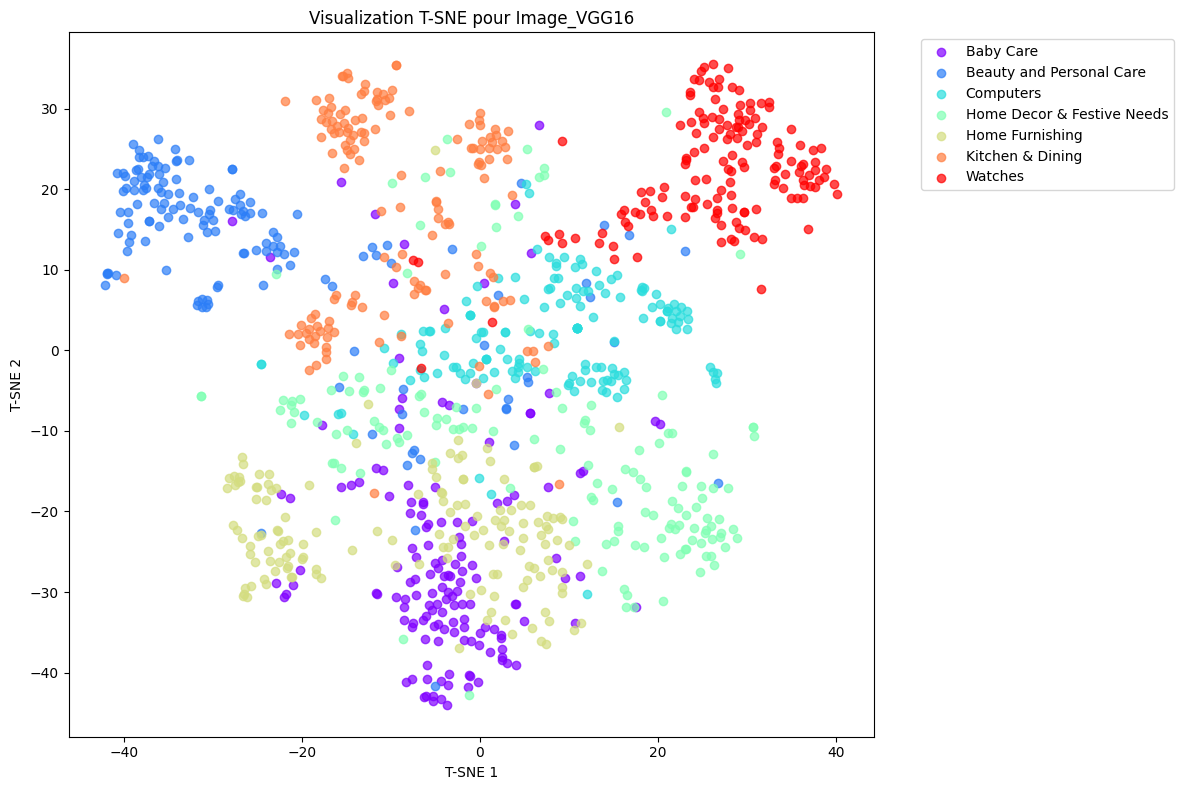


Traitement des features ResNet50...
Application de PCA pour réduire la dimensionnalité de Image_ResNet50...
Variance expliquée par PCA: 0.5193
Application de t-SNE sur Image_ResNet50...


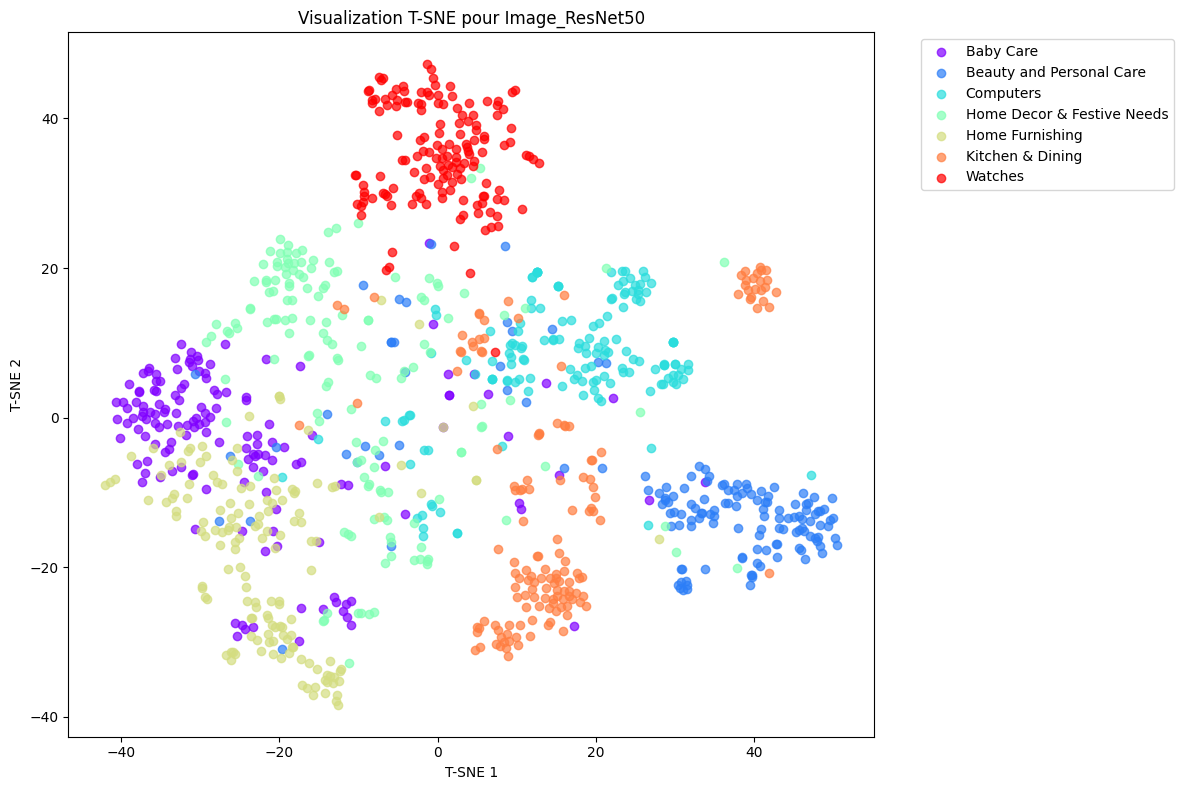


Traitement des features InceptionV3...
Application de PCA pour réduire la dimensionnalité de Image_InceptionV3...
Variance expliquée par PCA: 0.5345
Application de t-SNE sur Image_InceptionV3...


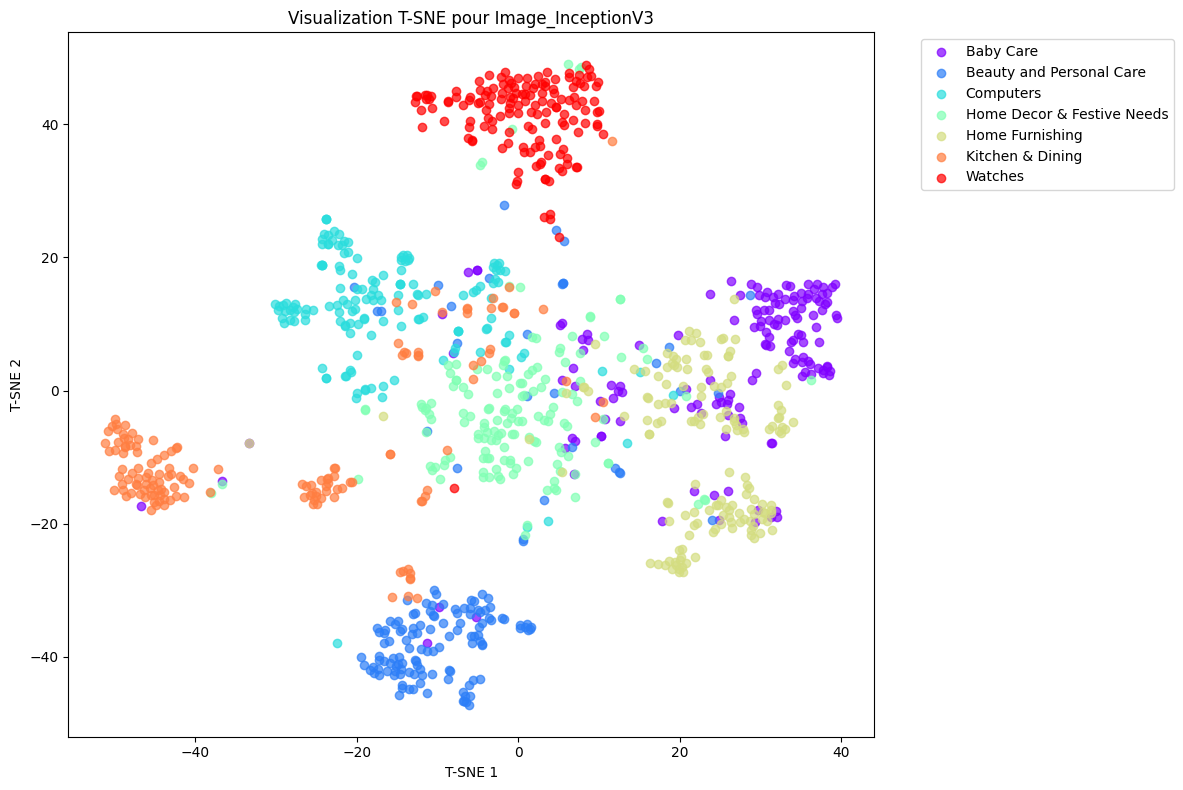

In [ ]:
# Visualiser toutes les features d'images
print("\nVisualisation des features d'images avec t-SNE...")
for feature_name, feature_data in image_features.items():
    print(f"\nTraitement des features {feature_name}...")
    apply_tsne_and_visualize(feature_data, f"Image_{feature_name}", df_balanced['main_category'])

### Interprétation de la visualisation pour ResNet50

En analysant la visualisation t-SNE des caractéristiques extraites par ResNet50, les résultats sont très prometteurs pour la faisabilité d'une classification automatique des produits.

La visualisation montre une séparation remarquable entre les différentes catégories de produits :

- 🔴 Les montres (Watches, en rouge) forment un groupe très distinct et compact dans la partie supérieure du graphique
- 🔵 Les produits de beauté (Beauty and Personal Care, en bleu) sont clairement regroupés dans la partie inférieure droite
- 🟣 Les produits pour bébés (Baby Care, en violet) se concentrent principalement dans la partie gauche
- 🟠 Les articles Kitchen & Dining (en orange) forment plusieurs clusters cohérents
- Ⓜ️ Les ordinateurs (Computers, en turquoise) sont relativement bien regroupés
- 🟢 Les produits Home Furnishing et Home Decor montrent une distribution plus éparse mais conservent une certaine cohésion

Cette séparation spatiale claire entre la plupart des catégories indique que **ResNet50 capture efficacement les caractéristiques visuelles discriminantes** qui différencient les types de produits. La présence de clusters distincts et bien définis suggère qu'un algorithme de classification supervisée pourrait **apprendre à reconnaître ces motifs**.

Le niveau élevé de séparation entre certaines catégories (comme les montres et les produits de beauté) et la cohésion interne de ces groupes confirment que la classification automatique est non seulement **faisable** mais potentiellement **performante avec ces caractéristiques visuelles**.

Cette visualisation t-SNE démontre clairement la **faisabilité d'un système de classification automatique des produits basé sur les caractéristiques visuelles extraites par ResNet50**, ce qui répond positivement à l'objectif principal de notre étude de faisabilité.

### Visualisation de la meilleure feature texte et la meilleure feature image

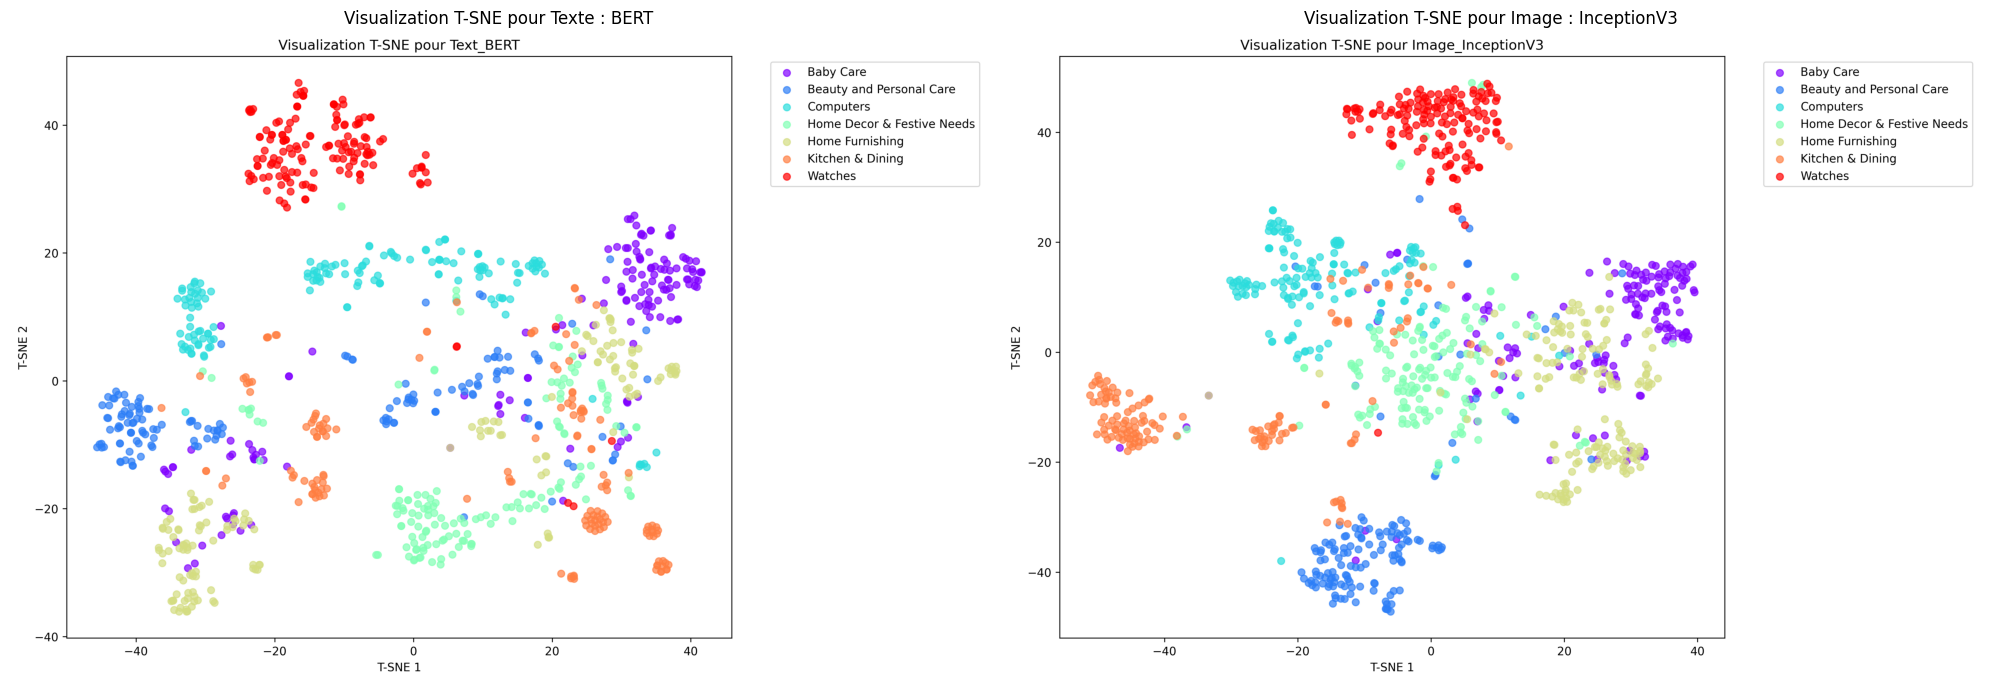

In [ ]:
# Visualisation cote à cote pour la meilleure feature text et la meilleure feature image

# Find the best text and image features (replace with your actual criteria)
best_text_feature_name = "BERT"  # Example: BERT
best_image_feature_name = "InceptionV3" # Example: VGG16

# Assuming 'apply_tsne_and_visualize' function is defined as in your original code
# and that it creates a plot and saves it as a file.

# Create subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Load and display the best text feature's visualization
text_image_path = os.path.join(features_dir, f"tsne_text_{best_text_feature_name.lower()}.png")
text_img = plt.imread(text_image_path)
axes[0].imshow(text_img)
axes[0].set_title(f"Visualization T-SNE pour Texte : {best_text_feature_name}")
axes[0].axis('off')


# Load and display the best image feature's visualization
image_image_path = os.path.join(features_dir, f"tsne_image_{best_image_feature_name.lower()}.png")
image_img = plt.imread(image_image_path)
axes[1].imshow(image_img)
axes[1].set_title(f"Visualization T-SNE pour Image : {best_image_feature_name}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Bonus: Combinaison des meilleures features textuelles et d'images

In [ ]:
# Bonus: Combinaison des meilleures features textuelles et d'images
print("\nCombiner les meilleures features textuelles et d'images...")

# À ce stade, vous pourriez choisir les meilleures features en fonction des visualisations
# Par exemple, combiner BERT pour le texte et ResNet50 pour les images
best_text_features = bert_features  # À ajuster selon les résultats de votre analyse
best_image_features = resnet_features  # À ajuster selon les résultats de votre analyse

# Normaliser les features
scaler_text = StandardScaler()
scaler_image = StandardScaler()
scaled_text = scaler_text.fit_transform(best_text_features)
scaled_image = scaler_image.fit_transform(best_image_features)

# Combiner les features
# Choisir un ratio pour équilibrer l'importance du texte et des images (à ajuster selon vos besoins)
combined_features = np.hstack([scaled_text * 0.5, scaled_image * 0.5])

# Visualiser les features combinées
apply_tsne_and_visualize(combined_features, "Combined_Text_Image", df_balanced['main_category'])


Combiner les meilleures features textuelles et d'images...
Application de PCA pour réduire la dimensionnalité de Combined_Text_Image...
Variance expliquée par PCA: 0.5148
Application de t-SNE sur Combined_Text_Image...


## Évaluation de la qualité des clusters avec K-means

Nous évaluons quantitativement les différentes méthodes d'extraction de caractéristiques que nous avons implémentées. Nous avons défini deux fonctions d'évaluation :

- `evaluate_clustering` qui applique une réduction de dimension préalable via PCA pour les caractéristiques de haute dimension.
- `evaluate_clustering_no_reduction` qui conserve toutes les dimensions d'origine.

Pour chaque méthode, nous standardisons les caractéristiques, appliquons l'algorithme **K-means** avec un nombre de clusters égal au nombre de catégories réelles, puis mesurons la qualité du clustering avec deux métriques complémentaires :

- **Adjusted Rand Index (ARI)** qui évalue la correspondance avec les catégories réelles
- **Score de Silhouette** qui mesure la cohésion interne des clusters.

Nous sauvegardons les résultats dans un **fichier CSV** pour référence future.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# Fonction pour évaluer la qualité du clustering
def evaluate_clustering(features, feature_name, true_labels):
    # Standardiser les features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Si la dimension est trop élevée, d'abord réduire avec PCA
    if scaled_features.shape[1] > 50:
        pca = PCA(n_components=50)
        reduced_features = pca.fit_transform(scaled_features)
    else:
        reduced_features = scaled_features

    # Déterminer le nombre de clusters à partir des labels réels
    n_clusters = len(set(true_labels))

    # Appliquer K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_features)

    # Calculer les métriques d'évaluation
    ari = adjusted_rand_score(true_labels, cluster_labels)
    silhouette = silhouette_score(reduced_features, cluster_labels)

    print(f"\nÉvaluation de {feature_name}:")
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")

    return ari, silhouette


# Version sans réduction de dimension
def evaluate_clustering_no_reduction(features, feature_name, true_labels):
    # Standardiser seulement les features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Utiliser directement les features standardisées
    n_clusters = len(set(true_labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Calculer les métriques
    ari = adjusted_rand_score(true_labels, cluster_labels)
    silhouette = silhouette_score(scaled_features, cluster_labels)

    print(f"\nÉvaluation de {feature_name} (sans réduction):")
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")

    return ari, silhouette


# Convertir les catégories en valeurs numériques pour l'évaluation
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(df_balanced['main_category'])


if not os.path.exists(os.path.join(features_dir, "evaluation_results.csv")):
  # Évaluer toutes les features
  results = []

  # # Évaluer les features textuelles
  # for feature_name, feature_data in text_features.items():
  #     ari, silhouette = evaluate_clustering(feature_data, f"Text_{feature_name}", numeric_labels)
  #     results.append({'Feature': f"Text_{feature_name}", 'ARI': ari, 'Silhouette': silhouette})

  # # Évaluer les features d'images
  # for feature_name, feature_data in image_features.items():
  #     ari, silhouette = evaluate_clustering(feature_data, f"Image_{feature_name}", numeric_labels)
  #     results.append({'Feature': f"Image_{feature_name}", 'ARI': ari, 'Silhouette': silhouette})

  # Évaluer les features textuelles
  for feature_name, feature_data in text_features.items():
      ari, silhouette = evaluate_clustering_no_reduction(feature_data, f"Text_{feature_name}", numeric_labels)
      results.append({'Feature': f"Text_{feature_name}", 'ARI': ari, 'Silhouette': silhouette})

  # Évaluer les features d'images
  for feature_name, feature_data in image_features.items():
      ari, silhouette = evaluate_clustering_no_reduction(feature_data, f"Image_{feature_name}", numeric_labels)
      results.append({'Feature': f"Image_{feature_name}", 'ARI': ari, 'Silhouette': silhouette})

  # Évaluer la combinaison
  ari, silhouette = evaluate_clustering_no_reduction(combined_features, "Combined_Text_Image", numeric_labels)
  results.append({'Feature': "Combined_Text_Image", 'ARI': ari, 'Silhouette': silhouette})

  # Afficher les résultats sous forme de tableau
  results_df = pd.DataFrame(results)
else :
  results_df = pd.read_csv(os.path.join(features_dir, "evaluation_results.csv"))

results_df = results_df.sort_values(by='ARI', ascending=False)
results_df.to_csv(os.path.join(features_dir, "evaluation_results.csv"), index=False)
print("\nRésumé des évaluations (trié par ARI):")
print(results_df)
print()

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.barh(results_df['Feature'], results_df['ARI'], color='skyblue')
plt.xlabel('Adjusted Rand Index (ARI)')
plt.title('Comparaison des méthodes de représentation')
plt.tight_layout()
plt.savefig(os.path.join(features_dir, "features_comparison_ari.png"), dpi=300, bbox_inches='tight')
plt.show()


Résumé des évaluations (trié par ARI):
               Feature       ARI  Silhouette
0       Image_ResNet50  0.505201    0.026614
1    Image_InceptionV3  0.443307    0.038592
2  Combined_Text_Image  0.437705    0.037888
3             Text_USE  0.411673    0.089591
4            Text_BERT  0.336934    0.085122
5          Image_VGG16  0.321884    0.034512
6          Text_TF-IDF  0.056186    0.064662
7           Image_SIFT  0.038952    0.094054
8        Text_Word2Vec  0.036876    0.221310
9    Text_Bag-of-Words  0.033901    0.193588



### Interprétation des résultats

- **Supériorité des méthodes visuelles avancées** : **ResNet50 (ARI = 0.505)** et **InceptionV3 (ARI = 0.443)** surpassent nettement toutes les autres approches, démontrant que les caractéristiques visuelles sont plus discriminantes que le texte pour notre tâche.
  
- **Efficacité des embeddings de texte modernes** : Parmi les méthodes textuelles, **USE (ARI = 0.412)** et **BERT (ARI = 0.337)** offrent des performances remarquablement supérieures aux approches classiques, confirmant l'avantage des modèles de langage contextuels.
  
- **Faiblesse des méthodes traditionnelles** : Les approches classiques comme **Bag-of-Words (ARI = 0.034)**, **Word2Vec (ARI = 0.037)**, **TF-IDF (ARI = 0.056)** et **SIFT (ARI = 0.039)** montrent des performances très limitées.
  
- **Complémentarité texte-image** : La **combinaison des caractéristiques textuelles et visuelles (ARI = 0.438)** se positionne en troisième place, suggérant que l'information textuelle apporte une valeur complémentaire, même si **elle n'améliore pas les performances de ResNet50 seul**.
  
- **Paradoxe silhouette/performance** : Les méthodes les moins performantes (Word2Vec, Bag-of-Words) présentent les meilleurs scores de Silhouette, indiquant qu'elles créent des clusters géométriquement compacts mais qui ne correspondent pas aux catégories réelles.

Ces résultats **confirment la faisabilité d'un système de classification automatique des produits**, avec **ResNet50 comme meilleure option individuelle**, tout en suggérant qu'une approche multimodale bien optimisée pourrait potentiellement améliorer encore les performances.

## Exemples de produits mal classés

In [ ]:
def afficher_produits_mal_classes(features, feature_name, df, n_examples=6):
    """
    Affiche des exemples de produits mal classés pour une méthode de feature extraction donnée.

    Args:
        features: Les features extraites
        feature_name: Nom de la méthode d'extraction
        df: DataFrame contenant les informations des produits
        n_examples: Nombre total d'exemples à afficher
    """
    print(f"Analyse des produits mal classés avec {feature_name}")

    # Standardiser les features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Réduire la dimensionnalité si nécessaire
    if scaled_features.shape[1] > 50:
        pca = PCA(n_components=50)
        reduced_features = pca.fit_transform(scaled_features)
    else:
        reduced_features = scaled_features

    # Appliquer K-means avec le nombre de catégories réelles
    n_clusters = len(df['main_category'].unique())
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_features)

    # Convertir les catégories en valeurs numériques
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(df['main_category'])

    # Mapper les clusters aux catégories réelles
    cluster_to_category = {}
    for cluster in range(n_clusters):
        # Pour chaque cluster, trouver la catégorie majoritaire
        true_cats_in_cluster = true_labels[cluster_labels == cluster]
        if len(true_cats_in_cluster) > 0:
            most_common_cat = np.bincount(true_cats_in_cluster).argmax()
            cluster_to_category[cluster] = most_common_cat

    # Identifier les produits mal classés
    predicted_categories = np.array([cluster_to_category.get(c, -1) for c in cluster_labels])
    misclassified_indices = np.where(true_labels != predicted_categories)[0]

    if len(misclassified_indices) == 0:
        print("Aucun produit mal classé trouvé!")
        return

    print(f"Nombre de produits mal classés: {len(misclassified_indices)} sur {len(df)} ({100*len(misclassified_indices)/len(df):.1f}%)")

    # Sélectionner aléatoirement des exemples
    np.random.seed(42)
    if len(misclassified_indices) > n_examples:
        selected_indices = np.random.choice(misclassified_indices, n_examples, replace=False)
    else:
        selected_indices = misclassified_indices

    # Afficher les exemples
    n_cols = 3
    n_rows = (len(selected_indices) + n_cols - 1) // n_cols
    plt.figure(figsize=(15, 5 * n_rows))

    for i, idx in enumerate(selected_indices):
        plt.subplot(n_rows, n_cols, i + 1)

        # Afficher l'image
        try:
            img_path = df.iloc[idx]['image_path']
            if os.path.exists(img_path):
                img = plt.imread(img_path)
                plt.imshow(img)
            else:
                plt.text(0.5, 0.5, 'Image non disponible', ha='center', va='center')
                plt.axis('off')
        except Exception as e:
            plt.text(0.5, 0.5, f'Erreur: {str(e)}', ha='center', va='center')
            plt.axis('off')

        # Ajouter un titre
        vrai_categorie = label_encoder.inverse_transform([true_labels[idx]])[0]
        cluster = cluster_labels[idx]
        predit_categorie = label_encoder.inverse_transform([cluster_to_category.get(cluster, -1)])[0]

        nom_produit = df.iloc[idx]['product_name']
        if len(nom_produit) > 40:
            nom_produit = nom_produit[:37] + "..."

        plt.title(f"Vrai: {vrai_categorie}\nClassé: {predit_categorie}\n{nom_produit}")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle(f"Exemples de produits mal classés - {feature_name}", fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

Analyse des produits mal classés avec Text BERT
Nombre de produits mal classés: 437 sur 1050 (41.6%)


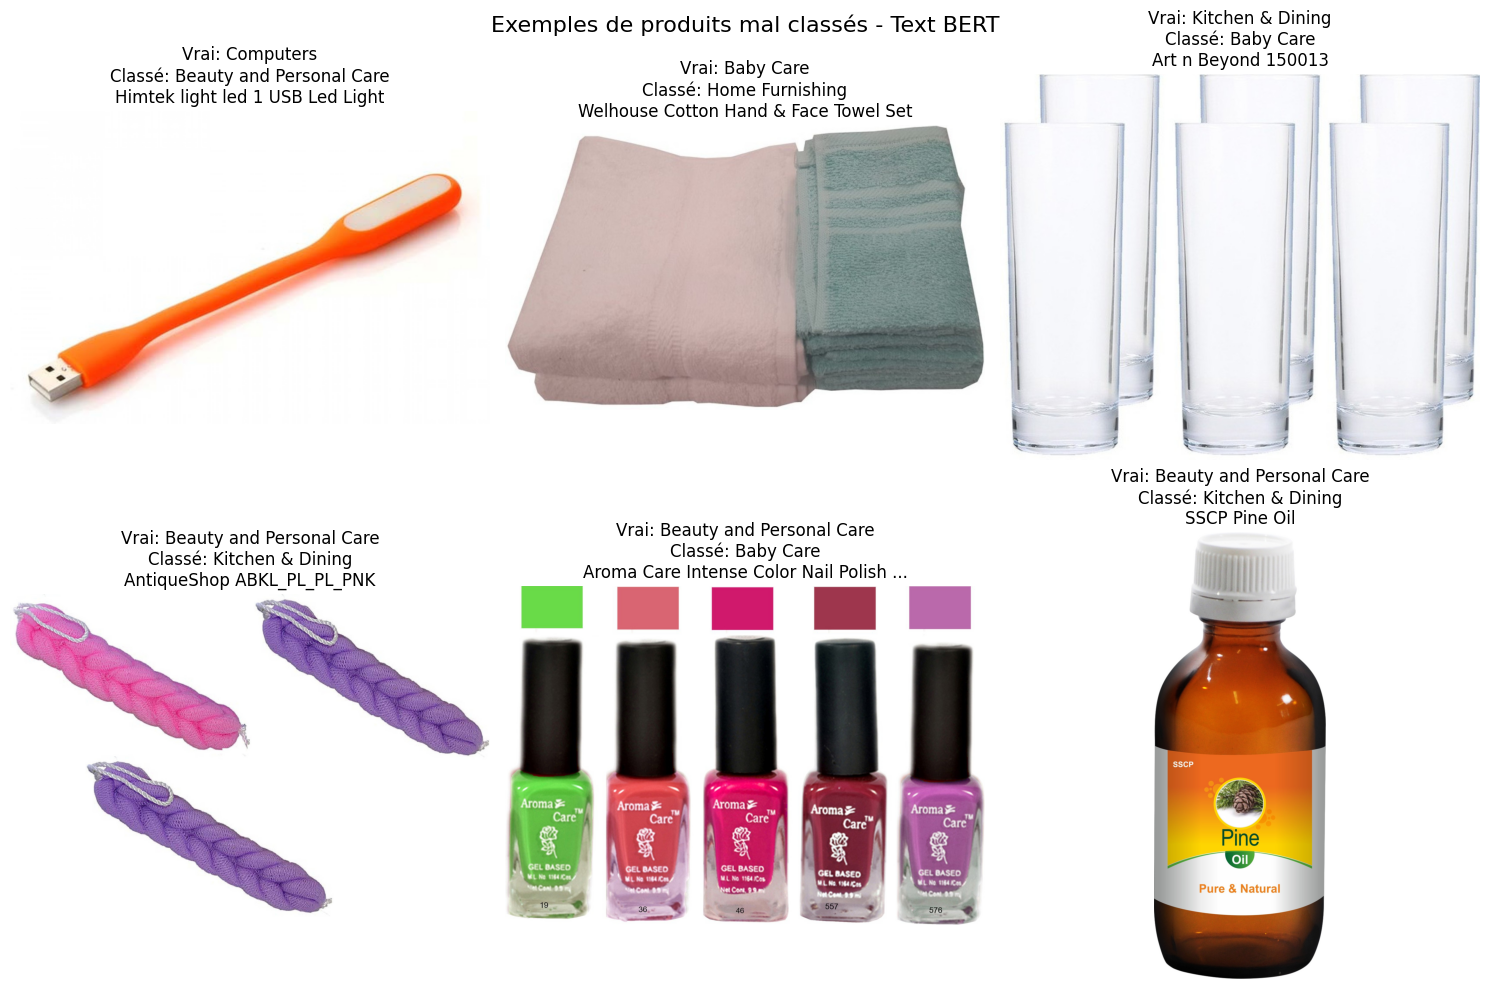

In [ ]:
# Pour une feature textuelle:
afficher_produits_mal_classes(text_features['BERT'], "Text BERT", df_balanced)

Analyse des produits mal classés avec Image ResNet50
Nombre de produits mal classés: 246 sur 1050 (23.4%)


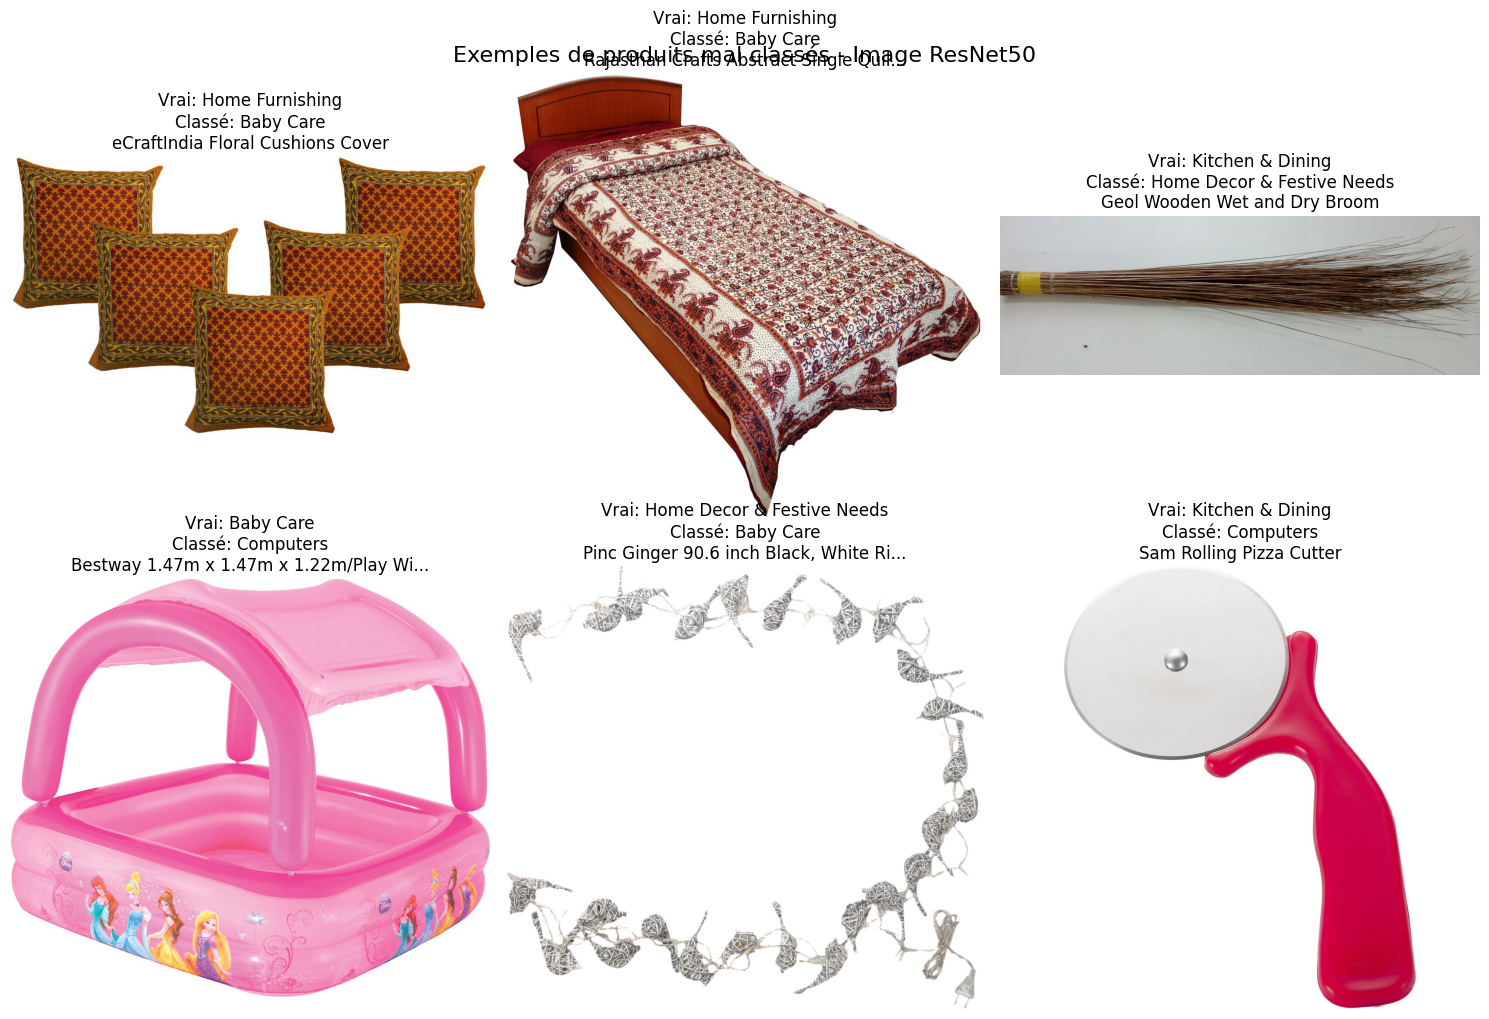

In [ ]:
# Pour une feature d'image:
afficher_produits_mal_classes(image_features['ResNet50'], "Image ResNet50", df_balanced)

Analyse des produits mal classés avec Combined Text+Image
Nombre de produits mal classés: 346 sur 1050 (33.0%)


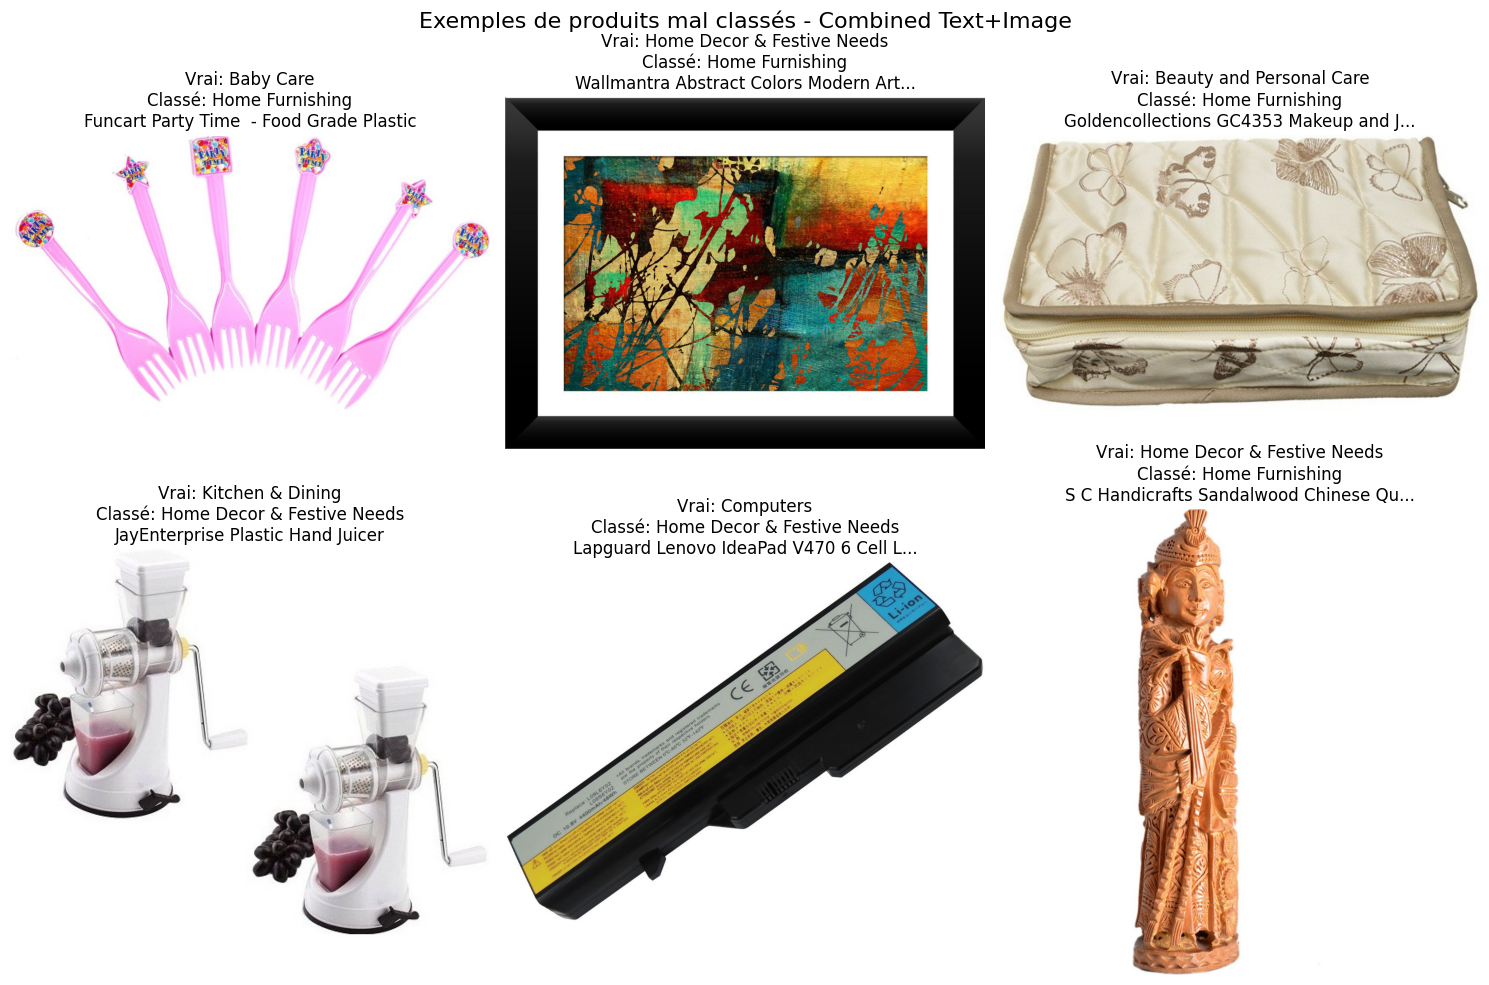

In [ ]:
# Pour les features combinées:
afficher_produits_mal_classes(combined_features, "Combined Text+Image", df_balanced)

## Conclusion et Interprétation des résultats de clustering

Ces résultats révèlent des informations très intéressantes sur les performances des différentes méthodes d'extraction de caractéristiques pour notre tâche de classification de produits e-commerce.

## Analyse générale des scores ARI

L'ARI (Adjusted Rand Index) mesure la correspondance entre les clusters détectés et les catégories réelles des produits. Voici l'interprétation des scores obtenus :

1. **Modèles CNN pour les images** : Les meilleurs scores sont obtenus par les modèles de vision par ordinateur avancés :
   - ResNet50 (ARI = 0.505) arrive en tête, suivi par InceptionV3 (ARI = 0.443)
   - Ces architectures profondes captent efficacement les caractéristiques visuelles distinctives des différentes catégories de produits

2. **Embeddings textuels modernes** :
   - USE (ARI = 0.412) et BERT (ARI = 0.337) sont nettement supérieurs aux méthodes traditionnelles
   - Ces modèles comprennent mieux la sémantique des descriptions de produits

3. **Approches traditionnelles** : Les méthodes classiques comme Bag-of-Words (ARI = 0.034), TF-IDF (ARI = 0.056), Word2Vec (ARI = 0.037) et SIFT (ARI = 0.039) obtiennent des performances significativement plus faibles

4. **Combinaison texte-image** : L'approche combinée (ARI = 0.438) performe bien mais n'améliore pas le meilleur modèle image (ResNet50)

## Conclusions importantes

1. **Supériorité des modèles profonds** : Les architectures CNN modernes (ResNet50, InceptionV3) et les embeddings textuels avancés (USE, BERT) surpassent largement les méthodes traditionnelles pour cette tâche.

2. **Prédominance des caractéristiques visuelles** : Les images semblent contenir plus d'informations discriminantes que le texte pour distinguer les catégories de produits dans votre jeu de données.

3. **Approche multimodale** : La combinaison texte-image (ARI = 0.438) n'améliore pas ResNet50 seul (ARI = 0.505), ce qui suggère que l'information visuelle domine ou que la méthode de fusion utilisée n'est pas optimale.

4. **Non-réduction de dimension bénéfique** : Conserver toutes les dimensions préserve des informations cruciales, particulièrement pour les modèles profonds comme ResNet50 et USE.

## Recommandations

1. **Privilégier ResNet50** comme base pour votre système de classification automatique de produits.

2. **Explorer des méthodes de fusion plus sophistiquées** pour les caractéristiques texte-image qui pourraient dépasser les performances des modèles individuels.

3. **Analyser les erreurs de classification** de ResNet50 pour identifier les catégories problématiques et les améliorations possibles.

4. **Conserver toutes les dimensions** pour les modèles profonds au lieu d'appliquer une réduction de dimension, car cela semble préserver des informations discriminantes importantes.

Ces résultats démontrent clairement la faisabilité de votre projet d'attribution automatique de catégories de produits, avec ResNet50 offrant le meilleur potentiel pour cette tâche.